## Bottleneck Toy Example

We look at a toy example where we expect short bursts to out perform the greedy aceptance function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy import stats
from itertools import product 
import networkx as nx

## Set up toy bottleneck graphs

In [2]:
def find_first(nodes, val, score="w"):
    """ Returns the first node in `nodes` that has the score `val`.
    """
    for n in nodes:
        if nodes[n][score] == val:
            return n
    raise ValueError

def bottle_neck_graph(k_size, p_size, score="w", sign="sign"):
    """ Returns a bottle neck graph with two complete graphs (one positive scoring and 
        one negative scoring) connected by a path graph which scores highest on the endpoints 
        and lowest in the center. 
        
        Args:
            k_size (int) : Size of the complete graphs
            p_size (int) : Length of the path graph that connects the complete graphs
            score  (str) : Name of field that will hold the score. 
    """

    pos = nx.complete_graph(k_size)
    neg = nx.complete_graph(k_size)
    path = nx.path_graph(p_size)
        
    for node in pos.nodes():
        pos.nodes[node][score] = random.choice([1, 2])
        pos.nodes[node][sign] = "pos"
    for node in neg.nodes():
        neg.nodes[node][score] = random.choice([-1, -2])
        neg.nodes[node][sign] = "neg"

    path_len = len(path.nodes)
    for n in range(int(np.ceil(path_len / 2))):
        path.nodes[n][score] = path.nodes[path_len-n-1][score] = -n
        path.nodes[n][sign] = path.nodes[path_len-n-1][sign] = "path"
    
    ## merge graphs and add edges from path
    G = nx.disjoint_union_all([pos, path, neg])

    # the path should be connected to nodes with score +1, -1
    pos_connector = find_first(pos.nodes(), 1)
    neg_connector = find_first(neg.nodes(), -1)
    
    G.add_edges_from([(pos_connector,k_size), (k_size+p_size-1, k_size+p_size+neg_connector)])
    test_bottleneck_graph(G)
    
    return G

def test_bottleneck_graph(G, score="w", sign="sign"):
    """ Some simple tests that raise an Assertion Error for the bottleneck graph `G`.
    """
    # all pos values should be in {1, 2}
    pos_nodes = [node for node in G.nodes if G.nodes[node][sign] == "pos"]
    assert(G.nodes[node][score] in [1, 2] for node in pos_nodes)
    
    # all neg values should be in {-1, -2}
    neg_nodes = [node for node in G.nodes if G.nodes[node][sign] == "neg"]
    assert(G.nodes[node][score] in [-1, -2] for node in neg_nodes)

    # only 2 zeros, at either end of the path, path should be connected to +1, -1
    zero_nodes = [node for node in G.nodes if G.nodes[node][score] == 0]
    assert(len(zero_nodes) == 2)
    
    neg_found = pos_found = False
    for z_node in zero_nodes:
        neighbor_signs = [G.nodes[n][sign] for n in G.neighbors(z_node)]
        neighbor_scores = [G.nodes[n][score] for n in G.neighbors(z_node)]
        if "neg" in neighbor_signs:
            assert(set(neighbor_signs) == {"neg", "path"})
            assert(set(neighbor_scores) == {-1, -1})
            neg_found = True
        elif "pos" in neighbor_signs:
            assert(set(neighbor_signs) == {"pos", "path"})
            assert(set(neighbor_scores) == {-1, 1})
            pos_found = True
    assert(neg_found and pos_found)
    
def get_starting_point(G, score="w", sign="sign"):
    """ Returns a node intended to be used as a starting point that has the lowest score in the graph `G`.
    """
    neg_nodes = [node for node in G.nodes if G.nodes[node][sign] == "neg"]
    
    minimum_node = None
    minimum_score = 0
    for node in neg_nodes:
        if G.nodes[node][score] < minimum_score:
            minimum_score = G.nodes[node][score]
            minimum_node = node
    return minimum_node

def get_starting_point_neg1(G, score="w", sign="sign"):
    """ Returns a node in the negative nodes whose values is -1. 
        
        This function is specific to generate a particular figure for the paper that looks cleaner.
    """
    neg_nodes = [node for node in G.nodes if G.nodes[node][sign] == "neg"]
    for n in neg_nodes:
        if G.nodes[n][score] == -1:
            return n
    raise ArgumentError("No node had a score of -1, re-build the graph again.")

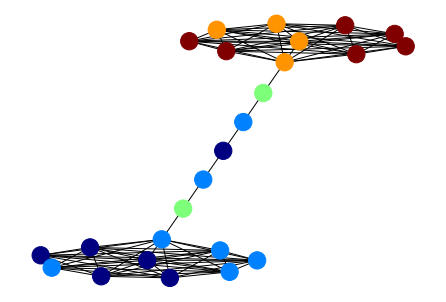

In [3]:
G = bottle_neck_graph(10,5)
nx.draw_kamada_kawai(G, node_color=[G.nodes[n]["w"] for n in G.nodes], cmap="jet")
# plt.savefig("plots/bottleneck_graph.png")

## Set up optimization functions

In [4]:
def random_walk(G, iters, score, start_node):
    """ Perform a random walk on graph `G` for `iters` steps starting at node `start_node`.
        Returns an array of all the scores observed, and the node with the maximum score.
        
        Other Args:
            `score` (str): field in each node of the graph that stores the score of the node.
    """
    rw = np.zeros(iters)
    rw[0] = G.nodes[start_node][score]
    curr_node = start_node
    max_node = start_node
    
    for i in range(1,iters):
        curr_node = np.random.choice(list(G.neighbors(curr_node)))
        rw[i] = G.nodes[curr_node][score]
        if rw[i] >= G.nodes[max_node][score]:
            max_node = curr_node
            
    return rw, max_node

def tilted_run(G, iters, score, start_node, q):
    """ Perform a tilted walk on graph `G` for `iters` steps starting at node `start_node`.
        A tilted walk is one where you take a step only if you strictly improve your score
        OR if your score doesn't improve, take a step with a probability `q`.
        
        Returns an array of all the scores observed, and the node with the maximum score.
        
        Other Args:
            `score` (str): field in each node of the graph that stores the score of the node.
    """
    tw = np.zeros(iters)
    tw[0] = G.nodes[start_node][score]
    curr_node = start_node
    max_node = start_node
    
    for i in range(1,iters):
        while True:
            proposal = np.random.choice(list(G.neighbors(curr_node)))
            if G.nodes[proposal][score] >= G.nodes[curr_node][score]: break
            if random.random() < q: break
        
        curr_node = proposal
        tw[i] = G.nodes[curr_node][score]
        if tw[i] >= G.nodes[max_node][score]:
            max_node = curr_node
            
    return tw, max_node


def short_burst(G, burst_len, num_bursts, score, start_node):
    """ Perform a short burst of length `burst_len` on the graph `G` for `num_bursts`
        number of times, starting at node `start_node`. 
        
        A short burst is when you do short random walks of length `burst_len`
        and then teleport yourself to wherever you observe the maximum score.
        Note: After each burst, the first index of the new burst represents a __new__
        step **after** the teleportation.
        
        Returns 
        1.  a short_burst array of length (burst_size * num_bursts) where the
            first `burst_len` indices are the scores observed in the first burst, the next
            `burst_len` indices are the scores observed in the second burst, and so on.
        2.  the node at which the maximum score was observed.
        
    """
    assert(burst_len > 1), "Use greedy_run() for burst_len == 1 instead."
    
    sb = np.zeros(burst_size*num_bursts)
    curr_node = start_node
    curr_max = start_node
    max_node = start_node
    
    for i in range(num_bursts):
        for j in range(burst_size):
            k = i*burst_size + j
            
            # the teleportation at the start of a new burst
            if j == 0:
                curr_node = curr_max 
            
            curr_node = np.random.choice(list(G.neighbors(curr_node)))
            if G.nodes[curr_node][score] >= G.nodes[curr_max][score]: 
                curr_max = curr_node
                    
            sb[k] = G.nodes[curr_node][score]
            if sb[k] >= G.nodes[max_node][score]:
                max_node = curr_node
                
    return sb, max_node

def greedy_run(G, iters, score, start_node):
    """ Performs a greedy run on graph `G` for `iters` steps starting at node `start_node`.
        
        A greedy run is one where you take a step only when your score is strictly greater 
        than or equal to your previous score. A greedy run is equivalent to a burst of 
        length 1 / size = 2.
        
        Returns an array of all the scores observed, and the node with the maximum score.
    """
    gw = np.zeros(iters)
    gw[0] = G.nodes[start_node][score]
    curr_node = start_node
    max_node = start_node
    
    for i in range(1,iters):
        proposal = np.random.choice(list(G.neighbors(curr_node)))
        if G.nodes[proposal][score] >= G.nodes[curr_node][score]: curr_node = proposal
        gw[i] = G.nodes[curr_node][score]
        if gw[i] >= G.nodes[max_node][score]:
            max_node = curr_node
            
    return gw, max_node

## Run simulations

In [5]:
K = 20
P = 7
N = 100
iters = 2400
score = "w"
save_figs = True
G = bottle_neck_graph(K, P)
start = get_starting_point_neg1(G)

In [6]:
# random, tilted with p=0.25 and greedy runs
print("Doing {} Random walks...".format(N))
rw = [random_walk(G, iters, score, start) for n in range(N)]
print("Doing {} Biased walks with acceptance prob={}...".format(N, 0.75))
tw_pt75 = [tilted_run(G, iters, score, start, 0.75) for n in range(N)]
print("Doing {} Biased walks with acceptance prob={}...".format(N, 0.5))
tw_pt5 = [tilted_run(G, iters, score, start, 0.5) for n in range(N)]
print("Doing {} Biased walks with acceptance prob={}...".format(N, 0.25))
tw_pt25 = [tilted_run(G, iters, score, start, 0.25) for n in range(N)]
print("Doing {} Biased walks with acceptance prob={}...".format(N, 0.125))
tw_pt125 = [tilted_run(G, iters, score, start, 0.125) for n in range(N)]
print("Doing {} Greedy runs...".format(N))
gw = [greedy_run(G, iters, score, start) for n in range(N)]

print("Doing short bursts runs...")
bursts = []
for burst_size in [2, 5, 10, 20, 40, 100]:
    bursts.append([short_burst(G, 
                               burst_size, 
                               int(iters/burst_size), 
                               score, 
                               start) 
                   for n in range(N)])
    
[sb3, sb5, sb10, sb20, sb40, sb100] = bursts

Doing 100 Random walks...
Doing 100 Biased walks with acceptance prob=0.75...
Doing 100 Biased walks with acceptance prob=0.5...
Doing 100 Biased walks with acceptance prob=0.25...
Doing 100 Biased walks with acceptance prob=0.125...
Doing 100 Greedy runs...
Doing short bursts runs...


## Make figures

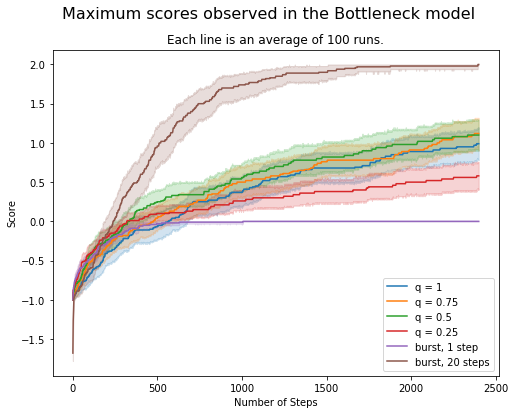

In [7]:
plt.figure(figsize=(8,6))
plt.suptitle("Maximum scores observed in the Bottleneck model", fontsize=16)
plt.title("Each line is an average of 100 runs.", fontsize=12)
plt.xlabel("Number of Steps")
plt.ylabel("Score")

sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in rw]).flatten(), 
             x=[i for i in range(iters)]*N, label="q = 1")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in tw_pt75]).flatten(), 
             x=[i for i in range(iters)]*N, label="q = 0.75")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in tw_pt5]).flatten(), 
             x=[i for i in range(iters)]*N, label="q = 0.5")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in tw_pt25]).flatten(), 
             x=[i for i in range(iters)]*N, label="q = 0.25")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in gw]).flatten(), 
             x=[i for i in range(iters)]*N, label="burst, 1 step")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="burst, 20 steps")

if save_figs:
    plt.savefig("bottleneck_walks_and_bursts_K{k}_P{p}_iters{iters}.png".format(k=K, p=P, iters=iters)
                , dpi=300, bbox_inches="tight")
else:
    plt.show()

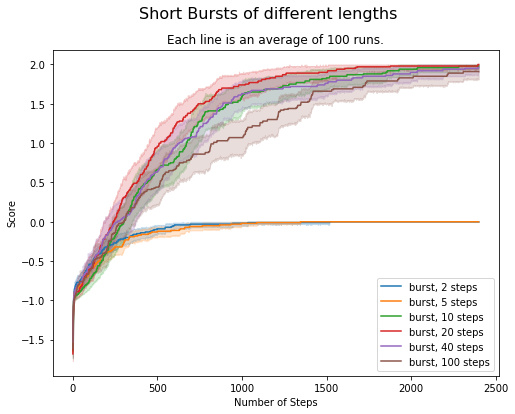

In [8]:
plt.figure(figsize=(8,6))
plt.suptitle("Short Bursts of different lengths", fontsize=16)
plt.title("Each line is an average of 100 runs.", fontsize=12)
plt.xlabel("Number of Steps")
plt.ylabel("Score")

sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb3]).flatten(), 
             x=[i for i in range(iters)]*N, label="burst, 2 steps")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb5]).flatten(), 
             x=[i for i in range(iters)]*N, label="burst, 5 steps")#, ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb10]).flatten(), 
             x=[i for i in range(iters)]*N, label="burst, 10 steps")#, ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="burst, 20 steps")#, ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb40]).flatten(), 
             x=[i for i in range(iters)]*N, label="burst, 40 steps")#, ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb100]).flatten(), 
             x=[i for i in range(iters)]*N, label="burst, 100 steps")#, ci="sd")

if save_figs:
    plt.savefig("burst_sizes_K{k}_P{p}_iters{iters}.png".format(k=K, p=P, iters=iters)
                , dpi=300, bbox_inches="tight")
else:
    plt.show()

### Misc: variable length short bursts, unused in the paper/analysis

In [ ]:
def variable_short_bursts(G, iters, score, start_node, stuck_buffer=10):
    """ Short Burst approach which doubles the burst length 
        if it has been stuck for stuck_buffer*burst length.
        
        Note: unused.
    """ 
    sb = np.zeros(iters)
    burst_len = 2
    time_stuck = 0
    cur_node = start_node
    cur_max = start_node
    max_node = start_node
    k = 0
    
    while(k < iters):
        for j in range(burst_len):
            if j == 0: cur_node = cur_max
            else:
                cur_node = np.random.choice(list(G.neighbors(cur_node)))
                if G.node[cur_node][score] > G.node[cur_max][score]: cur_max = cur_node
            sb[k] = G.node[cur_node][score]
            
            if sb[k] <= G.node[max_node][score]: time_stuck += 1
            else: time_stuck = 0
                
            if sb[k] >= G.node[max_node][score]: max_node = cur_node
            k += 1
            if k >= iters: break
        if time_stuck >= stuck_buffer*burst_len : burst_len *= 2
    
    return sb, max_node, burst_len   


vsb5 = [variable_short_bursts(G, iters, "w", start, stuck_buffer=5) for n in range(N)]
vsb10 = [variable_short_bursts(G, iters, "w", start, stuck_buffer=10) for n in range(N)]
vsb20 = [variable_short_bursts(G, iters, "w", start, stuck_buffer=20) for n in range(N)]
vsb40 = [variable_short_bursts(G, iters, "w", start, stuck_buffer=40) for n in range(N)]

In [ ]:
plt.figure(figsize=(8,6))
plt.title("Optimization Functions")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in rw]).flatten(), 
             x=[i for i in range(iters)]*N, label="Random Walk", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in tw]).flatten(), 
             x=[i for i in range(iters)]*N, label="Tilted Walk p=0.25", ci="sd")
# sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in tw_8]).flatten(), 
#              x=[i for i in range(1000)]*N, ci="sd", label="Tilted Walk p=0.125")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in gw]).flatten(), 
             x=[i for i in range(iters)]*N, label="Greedy Walk", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="Short Burst k=20", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB", ci="sd")
plt.savefig("plots/bottle_neck/opt_functs_K20_P11.png")
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.title("Short Bursts w/ diff lengths")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb2]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 2", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb5]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 5", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb10]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 10", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 20", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb40]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 40", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb100]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 100", ci="sd")
plt.savefig("plots/bottle_neck/burst_lengths_K20_P11.png")

plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.title("Stuck buffers in variable bursts length function")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb5]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB 5", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb10]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB 10", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB 20", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb40]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB 40", ci="sd")
plt.savefig("plots/bottle_neck/stuck_buffers_K20_P11.png")

plt.show()